In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


## Goal:
- Each row in the dataset describes the characteristics of a house.
- Our goal is to predict the SalePrice, given these features.
- Our models are evaluated on the Root-Mean-Squared-Error (RMSE) between the log of the SalePrice predicted by our model, and the log of the actual SalePrice. Converting RMSE errors to a log scale ensures that errors in predicting expensive houses and cheap houses will affect our score equally.

In [2]:
# essentials
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

# Stats
from scipy.stats import skew, norm
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# Misc sklearn
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline

In [3]:
"""Read in the dataset"""
train = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test= pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")
sample_submission = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv")

train.shape, test.shape

((1460, 81), (1459, 80))

## EDA

- each row in the dataset describes the features of a house,
- our goal is to predict the SalePrice given these features

In [4]:
"""Preview the training data"""
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### Visualize the target variable - SalePrice

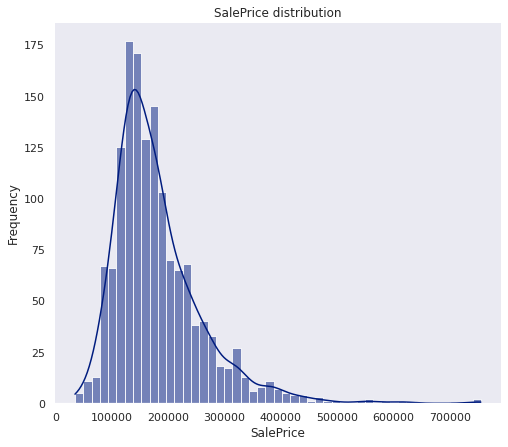

In [6]:
"""Let's visualize the distribution of SalePrice"""
# figure setup
sns.set_style("dark")
sns.set_context("notebook")
sns.set_color_codes(palette='dark')
f, ax = plt.subplots(figsize=(8, 7))
# visualize the target
sns.histplot(train['SalePrice'], color='b', kde=True)
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)
plt.show()


In [7]:
# skew and kurtosis
skew = train['SalePrice'].skew()
kurt = train['SalePrice'].kurt()

print(f'Skewness: {skew:.6f}')
print(f'Kurtosis: {kurt:.6f}')



Skewness: 1.882876
Kurtosis: 6.536282


### Separate the features by data type

In [8]:
print(train.dtypes.value_counts())
print("="*30)
print(test.dtypes.value_counts())

object     43
int64      35
float64     3
dtype: int64
object     43
int64      26
float64    11
dtype: int64


In [9]:
numeric = list(train.select_dtypes(include=['float64', 'int64'])) # list



**visualize some of the features in the dataset**

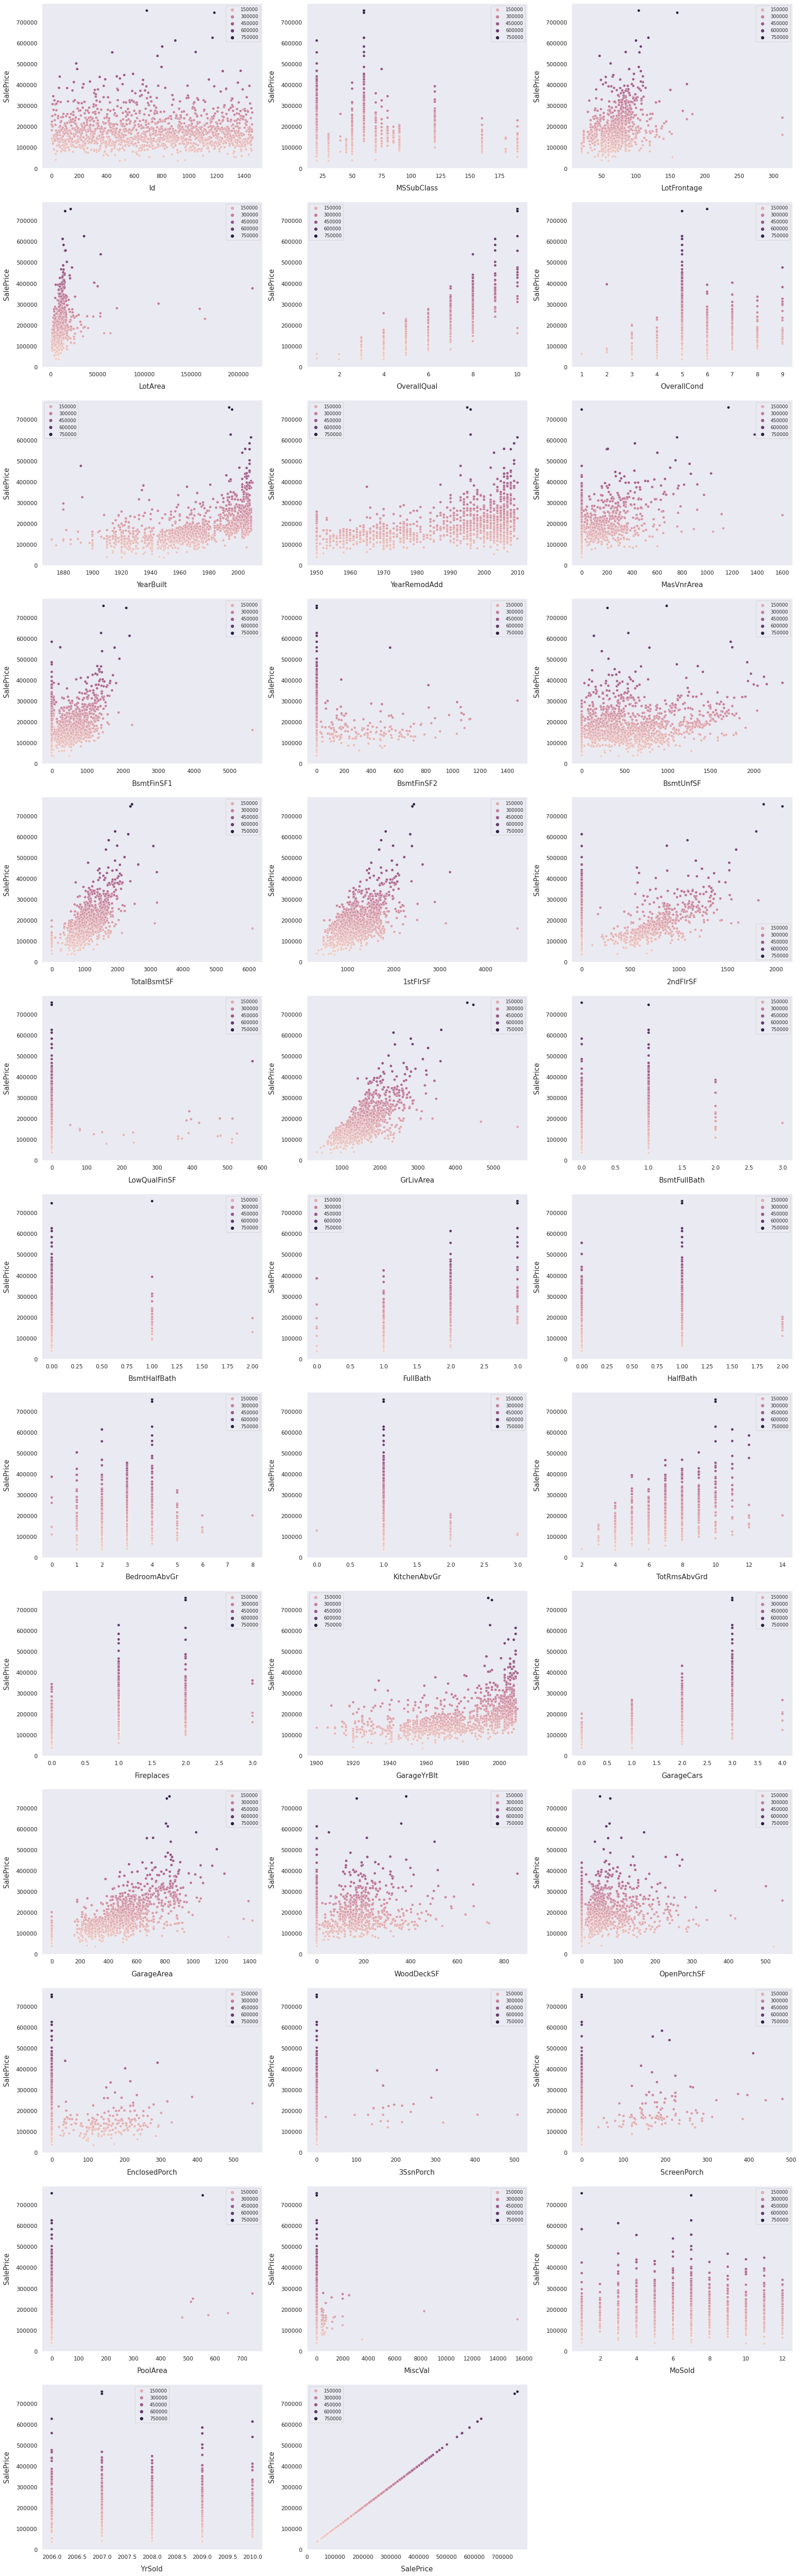

In [10]:
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(12, 120))
plt.subplots_adjust(right=2)
plt.subplots_adjust(top=2)
sns.color_palette("husl", 8)
for i, feature in enumerate(list(train[numeric])):

    plt.subplot(len(numeric), 3, i+1)
    sns.scatterplot(x=feature, y='SalePrice', data=train, hue='SalePrice')
    
    plt.xlabel('{}'.format(feature), size=15,labelpad=12.5)
    plt.ylabel('SalePrice', size=15, labelpad=12.5)
    
    for j in range(2):
        plt.tick_params(axis='x', labelsize=12)
        plt.tick_params(axis='y', labelsize=12)
    
    plt.legend(loc='best', prop={'size': 10})
plt.show()

plot how the features are correlated to each other, and to SalePrice

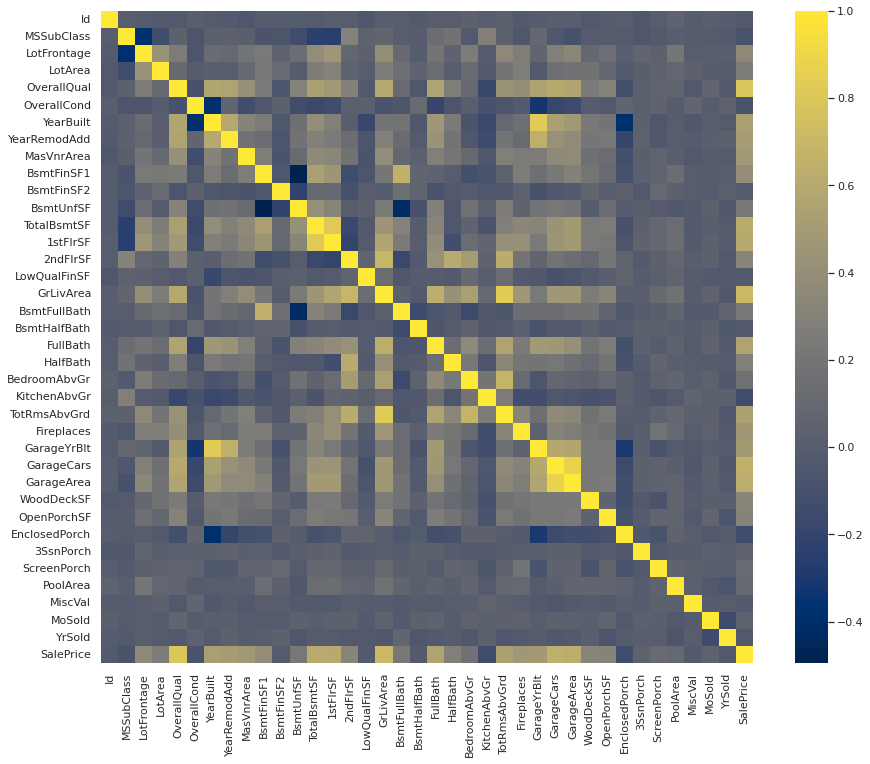

In [11]:
corr = train.corr()
plt.subplots(figsize=(15, 12))
sns.heatmap(corr, cmap='cividis', square=True, annot=False, fmt='.2f')

plt.show()

In [12]:
corr["SalePrice"].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

Remove the Ids 

In [13]:
train_ID = train['Id']
test_ID = test['Id']
print(train.shape, test.shape)
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)
print(train.shape, test.shape)

(1460, 81) (1459, 80)
(1460, 80) (1459, 79)


## Feature Engineering

Let's take a look at the distribution of the SalePrice.

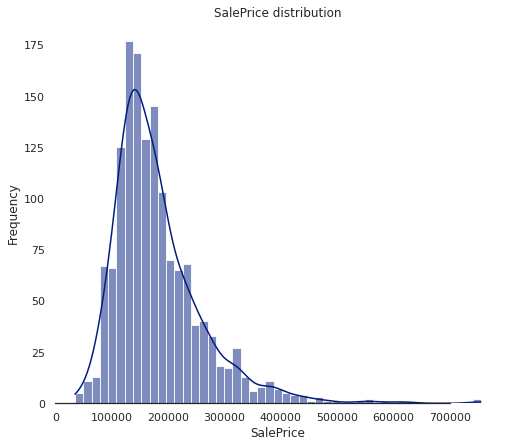

In [14]:
"""Let's visualize the distribution of SalePrice"""
# figure setup
sns.set_style("white")
sns.set_context("notebook")
sns.set_color_codes(palette='dark')
f, ax = plt.subplots(figsize=(8, 7))
# visualize the target
sns.histplot(train['SalePrice'], color='b', kde=True)
ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)
plt.show()

The SalePrice is skewed to the right. This is a problem because most ML models don't do well with non-normally distributed data. We can apply a log(1+x) tranform to fix the skew.

In [15]:
# log(1+x) transform
train["SalePrice"] = np.log1p(train["SalePrice"])

Let's plot the SalePrice again.

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)



 mu = 12.02 and sigma = 0.40



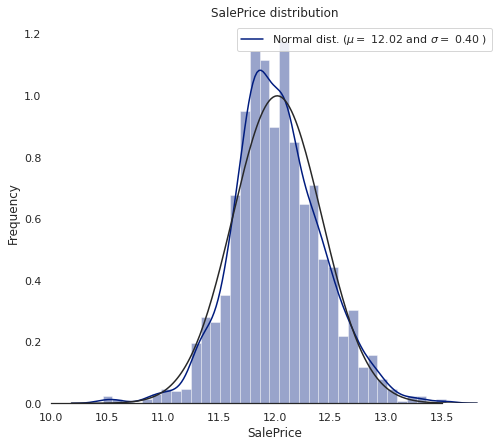

In [16]:
"""Let's visualize the distribution of SalePrice"""
# figure setup
sns.set_style("white")
sns.set_context("notebook")
sns.set_color_codes(palette='dark')
f, ax = plt.subplots(figsize=(8, 7))
# visualize the target
# sns.histplot(train['SalePrice'], color='b', kde=True)

sns.distplot(train['SalePrice'] , fit=norm, color="b");
# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')

ax.xaxis.grid(False)
ax.set(ylabel="Frequency")
ax.set(xlabel="SalePrice")
ax.set(title="SalePrice distribution")
sns.despine(trim=True, left=True)
plt.show()

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

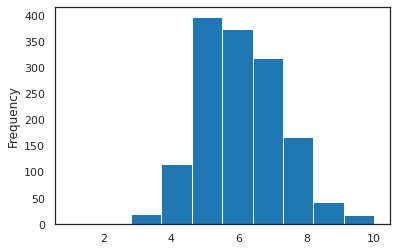

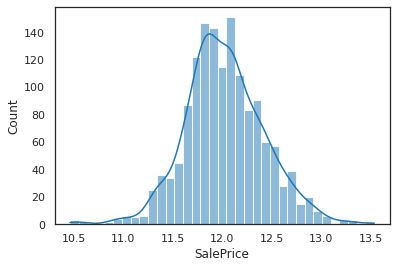

In [17]:
train['OverallQual'].plot.hist()
train['OverallQual'].value_counts().sort_index(ascending=False)

plt.figure()
sns.histplot(data=train, x=train['SalePrice'], kde=True)

In [18]:
train[train["OverallQual"] < 5].index.nunique() # count = 141
len(list((train[train["OverallQual"] < 5].index))) # equvilaent

141

In [19]:
train[train["GrLivArea"] > 4500].index.nunique()

2

### split features and labels

In [20]:
train_labels = train['SalePrice'].reset_index(drop=True)
train_features = train.drop(['SalePrice'], axis=1)
test_features = test

# combine train and test feature in order to apply the feature transformation pipeline 
# to the entire dataset

all_features = pd.concat([train_features, test_features]).reset_index(drop=True)
all_features.shape

(2919, 79)

## Fill missing values

Determine the percent of missing data

In [21]:
perc_miss = round(all_features.isna().mean()*100, 2).sort_values(ascending=False)
perc_miss[perc_miss > 0]

PoolQC          99.66
MiscFeature     96.40
Alley           93.22
Fence           80.44
FireplaceQu     48.65
LotFrontage     16.65
GarageYrBlt      5.45
GarageFinish     5.45
GarageQual       5.45
GarageCond       5.45
GarageType       5.38
BsmtExposure     2.81
BsmtCond         2.81
BsmtQual         2.77
BsmtFinType2     2.74
BsmtFinType1     2.71
MasVnrType       0.82
MasVnrArea       0.79
MSZoning         0.14
Functional       0.07
BsmtHalfBath     0.07
BsmtFullBath     0.07
Utilities        0.07
SaleType         0.03
BsmtFinSF1       0.03
KitchenQual      0.03
GarageCars       0.03
BsmtUnfSF        0.03
TotalBsmtSF      0.03
Exterior2nd      0.03
Exterior1st      0.03
GarageArea       0.03
Electrical       0.03
BsmtFinSF2       0.03
dtype: float64

comment 
> so we have quite a few features with missing values

### visualize the missing values in train dataset

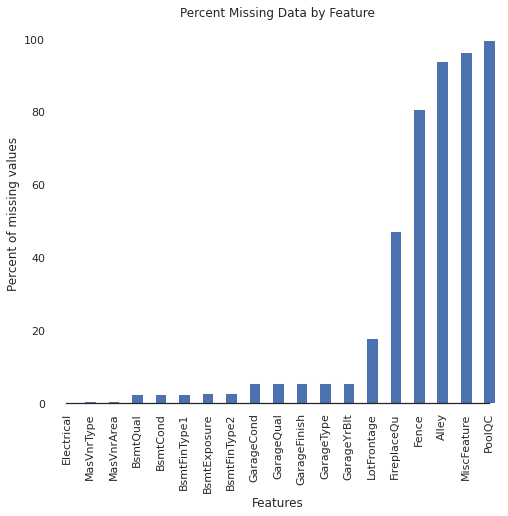

In [22]:
sns.set_style("white")
f, ax = plt.subplots(figsize=(8, 7))
sns.set_color_codes(palette='deep')

missing = round(train.isnull().mean()*100, 2)
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar(color='b')

ax.xaxis.grid(False)
ax.set(ylabel='Percent of missing values')
ax.set(xlabel='Features')
ax.set(title='Percent Missing Data by Feature')
sns.despine(trim=True, left=True)

plt.show()

We can now move through each of the features above and impute the missing values for each of them.

In [23]:
# Some of the non-numeric predictors are stored as numbers; convert them into strings 
all_features['MSSubClass'] = all_features['MSSubClass'].apply(str)
all_features['YrSold'] = all_features['YrSold'].astype('object')
all_features['MoSold'] = all_features['MoSold'].apply(str)

In [24]:


def handle_missing(features):
    # the data description states that Assume typical (Typ) unless deductions are warranted
    features['Functional'] = features['Functional'].fillna('Typ')
    # Replace the missing values in each column below with their mode
    features['Electrical'] = features['Electrical'].fillna(features['Electrical'].mode()[0])
    features['KitchenQual'] = features['KitchenQual'].fillna(features['KitchenQual'].mode()[0])
    features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
    features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
    features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])
    features['MSZoning'] = features['MSZoning'].fillna(features['MSZoning'].mode()[0])
    
    # the data description stats that NA refers to "No Pool"
    features['PoolQC'] =   features['PoolQC'].fillna("None")
    
    # Replacing the missing values with 0, since no garage = no cars in garage
    for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
        features[col] = features[col].fillna(0)
    
    # Replacing the missing values with None
    for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
        features[col] = features[col].fillna('None')
    
    # NaN values for these categorical basement features -> means there are no basement
    for col in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
        features[col] = features[col].fillna('None')
    
    # Group the by neighborhoods, and fill in missing value by the median LotFrontage of the neighborhood
    features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

    # For the rest of the categorical features, reaplce missing value with 'None'
    object_cols = list(all_features.select_dtypes(include='object'))
    for col in object_cols:
        features[col] = features[col].fillna('None')
    
    # For the rest of the numerical features, replace missing value with 0
    num_cols = list(all_features.select_dtypes(include=['int64', 'float64']))
    for col in num_cols:
        features[col] = features[col].fillna(0)
    
    return features
    
all_features = handle_missing(all_features)

In [25]:
all_features.dtypes.value_counts()
all_features.isna().sum().sum()

0

In [26]:

perc_miss = round(all_features.isna().mean()*100, 2).sort_values(ascending=False)
perc_miss.sum()

0.0

comment 
> there are no more missing values 

### Encode categorical features

In [27]:
all_features = pd.get_dummies(all_features).reset_index(drop=True)
all_features.shape

(2919, 329)

In [28]:
all_features.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,65.0,8450,7,5,2003,2003,196.0,706.0,0.0,150.0,...,0,0,0,1,0,0,0,0,1,0
1,80.0,9600,6,8,1976,1976,0.0,978.0,0.0,284.0,...,0,0,0,1,0,0,0,0,1,0
2,68.0,11250,7,5,2001,2002,162.0,486.0,0.0,434.0,...,0,0,0,1,0,0,0,0,1,0
3,60.0,9550,7,5,1915,1970,0.0,216.0,0.0,540.0,...,0,0,0,1,1,0,0,0,0,0
4,84.0,14260,8,5,2000,2000,350.0,655.0,0.0,490.0,...,0,0,0,1,0,0,0,0,1,0


In [29]:
# check if there are duplicated columns
all_features.columns.duplicated().sum()

0

### recreate training and test sets

In [30]:
X = all_features.iloc[:len(train_labels), :]
X_test = all_features.iloc[len(train_labels):, :]
X.shape, train_labels.shape, X_test.shape

((1460, 329), (1460,), (1459, 329))

### Train a model

In [31]:
from sklearn.model_selection import cross_val_score

def calculate_rmse(y_label, y_pred):
    return np.sqrt(mean_squared_error(y_label, y_pred))

def calculate_cv_rmse(model, X=X, cv=10):
    rmse = np.sqrt(-cross_val_score(model, X, train_labels, scoring='neg_mean_squared_error', cv=cv))
    return (rmse)

"""1) linear regression"""
lin_reg = LinearRegression()

"""2) DecisionTreeRegressor"""
tree_reg = DecisionTreeRegressor()

"""3) RandomForestRegressor"""
forest_reg = RandomForestRegressor()

regressors = [lin_reg, tree_reg, forest_reg]

#### get cross_validation scores for each model

In [32]:
scores = {}

for regressor in regressors:
    score = calculate_cv_rmse(regressor)
    scores[str(regressor)] = (score.mean(), score.std())

In [33]:
scores

{'LinearRegression()': (0.15283674369044942, 0.04540991085446065),
 'DecisionTreeRegressor()': (0.19612397477393273, 0.01750431107574763),
 'RandomForestRegressor()': (0.14077831583451955, 0.01777417820215906)}

In [34]:
scores_df = pd.DataFrame(scores, index=['rmse_mean', 'rmse_std'])
scores_df

,LinearRegression(),DecisionTreeRegressor(),RandomForestRegressor()
rmse_mean,0.152837,0.196124,0.140778
rmse_std,0.045410,0.017504,0.017774


### Fine tune the hyper parameters for
- RandomForestRegressor()

In [35]:
param_grid = [
    {'n_estimators':[3, 10, 30], 'max_features':[2, 4, 6, 8]},
    {'bootstrap':[False], 'n_estimators':[3, 10, 30], 'max_features':[2, 3, 4]}
]

forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error',
                          return_train_score=True, refit=True)
grid_search.fit(X, train_labels)

grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [36]:
grid_search.best_estimator_

RandomForestRegressor(max_features=8, n_estimators=30)

### Submit predictions

In [37]:
submission = pd.read_csv("../input/house-prices-advanced-regression-techniques/sample_submission.csv")
submission.shape


(1459, 2)

In [38]:
submission

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977
...,...,...
1454,2915,167081.220949
1455,2916,164788.778231
1456,2917,219222.423400
1457,2918,184924.279659


In [39]:
final_model = grid_search.best_estimator_

final_predictions = final_model.predict(X_test)

final_predictions.shape
type(final_predictions)

numpy.ndarray

In [40]:
final_pred_df = pd.DataFrame(np.expm1(final_predictions), columns=["SalePrice"])
final_pred_df

,SalePrice
0,124295.860206
1,156389.946832
2,186363.952327
3,197709.923151
4,204031.285969
...,...
1454,89889.733156
1455,93803.000260
1456,148508.702420
1457,113260.034755


### Append predictions from final_model

In [41]:
submission['SalePrice'] = final_pred_df

# Scale predictions
submission['SalePrice'] *= 1.001619

In [42]:
submission

,Id,SalePrice
0,1461,124497.095204
1,1462,156643.142156
2,1463,186665.675566
3,1464,198030.015517
4,1465,204361.612621
...,...,...
1454,2915,90035.264634
1455,2916,93954.867317
1456,2917,148749.138010
1457,2918,113443.402751


In [43]:
submission.to_csv('submission-ben-chen.csv', index=False)